In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import datetime
from sklearn.model_selection import train_test_split

import torch
import re
import os
import shutil
import glob
import zipfile
import cv2
import math

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print('device :', device)
print('Current :', torch.cuda.current_device())
print('Count :', torch.cuda.device_count())

device : cuda
Current : 0
Count : 1


In [6]:
total_df = pd.read_csv('골밀도 데이터/total_data.csv')
total_df = total_df[['No', '성별', 'boneage']]
total_df.columns = ['id', 'gender', 'boneage']
total_df['id'] = total_df['id'].astype('str')

mean_bone_age = total_df['boneage'].mean()
std_bone_age = total_df['boneage'].std()

total_df['boneage_z'] = (total_df['boneage'] - mean_bone_age)/(std_bone_age)

total_df.head()

,id,gender,boneage,boneage_z
0,1.jpg,F,9.750,0.032860
1,2.jpg,F,10.750,0.282805
2,3.jpg,F,11.125,0.376534
3,4.jpg,F,10.125,0.126589
4,5.jpg,F,9.875,0.064103


## 2. 이미지 전처리

In [8]:
total_path = '골밀도 데이터/data/'

> Grayscale

(1624, 1188)


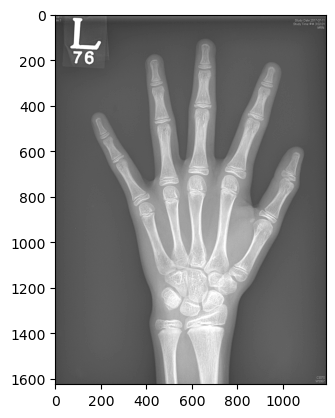

In [9]:
img = cv2.imread(total_path + '98.jpg', cv2.IMREAD_GRAYSCALE)
print(img.shape)
plt.imshow(img, 'gray')
plt.show()

> Resize

In [9]:
# 전체 이미지의 비율 평균 계산하여 resize 할 비율 결정
ratio = 0
for i in range(len(total_df.id)):
    img = cv2.imread(total_path + total_df['id'][i], cv2.IMREAD_GRAYSCALE)
    ratio += img.shape[0] / img.shape[1]

ratio / len(total_df.id)

1.2668465038913272

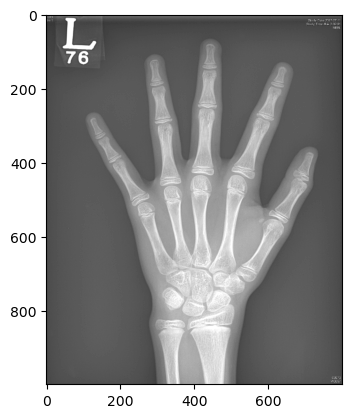

In [10]:
# 이미지 사이즈 재설정
img = cv2.imread(total_path + '98.jpg', cv2.IMREAD_GRAYSCALE)
resize_img = cv2.resize(img, (800, 1000))
plt.imshow(resize_img, 'gray')

> Normalize

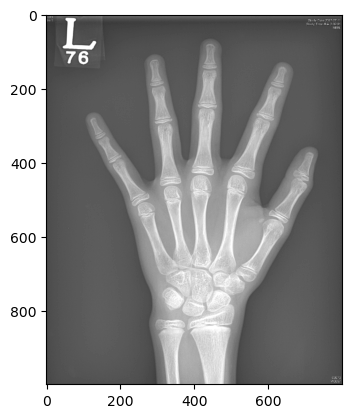

In [11]:
# 이미지 min max 정규화
normal_img = cv2.normalize(resize_img, None, 0, 255, cv2.NORM_MINMAX)
plt.imshow(normal_img, 'gray')

> Denoise
+ GaussianBlur
+ 흐림 효과를 넣어 노이즈를 부드럽게 만들어줌

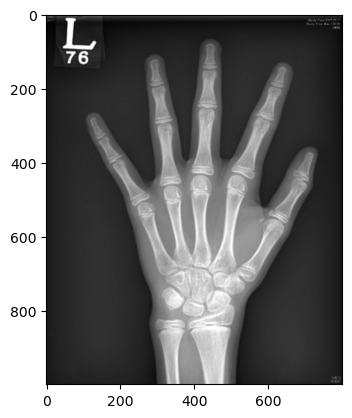

In [12]:
denoise_img = cv2.GaussianBlur(normal_img, (5, 5), -1)
plt.imshow(denoise_img,"gray")

> Equalize
+ createCLAHE(Contrast Limited Adaptive Histogram Equalization)
+ 이미지를 여러 작은 블록으로 나누어 각 블록에 대해 독립적으로 히스토그램 평탄화를 적용

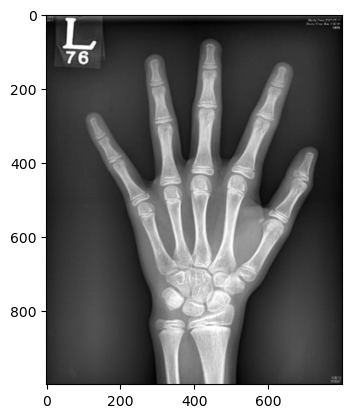

In [13]:
clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(3,3))
equal_img=clahe.apply(denoise_img)
plt.imshow(equal_img, 'gray')

In [14]:
pre_image_folder = '골밀도 데이터/pre_image/'
os.makedirs(pre_image_folder, exist_ok=True)

In [20]:
# fig, ax = plt.subplots(2,2, figsize = (10, 10))
for i in range(0, total_df.shape[0]):
    img_path = glob.glob(total_path + total_df.id[i])[0]
    
    img_name = img_path.split('/')[-1]
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # 이미지 사이즈 재설정
    resized_img = cv2.resize(img, (800, 1000))
    # ax[0,0].imshow(resized_img, 'gray')
    
    # 이미지 정규화
    normal_img=cv2.normalize(resized_img, None, 0, 255, cv2.NORM_MINMAX)
    # ax[0,1].imshow(normal_img, 'gray')
    
    # 이미지 노이즈 제거
    denoise_img = cv2.GaussianBlur(normal_img, (5, 5), 0)
    # ax[1,0].imshow(denoise_img, 'gray')
    
    # 이미지 평탄화
    clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(3,3))
    equal_img=clahe.apply(denoise_img)
    # ax[1,1].imshow(equal_img, 'gray')
    
    # 이미지 저장
    cv2.imwrite(pre_image_folder + img_name, equal_img)

## 3. 이미지 회전
+ 여기서부터 시작

In [3]:
data = pd.read_csv('골밀도 데이터/total_data.csv')
data.head()

,Group,등록번호,생년월일,성별,진료의,검사 시 나이,신장,체중,BMI,처방일자,시행일자,BA 1,BA 2,Unnamed: 14,No,boneage
0,1698,8255049,2007-08-03,F,1,9.969863,129.5,26.9,16.1,2017-01-09,2017-07-20,9.75,9.75,NaN,1.jpg,9.750
1,1897,8537405,2008-08-22,F,1,9.989041,132.0,31.0,17.8,2018-02-28,2018-08-16,10.50,11.00,NaN,2.jpg,10.750
2,1422,7942635,2005-01-19,F,1,10.008219,136.4,33.2,17.9,2015-01-20,2015-01-20,11.00,11.25,NaN,3.jpg,11.125
3,1475,7995857,2005-02-09,F,1,10.049315,133.5,31.2,17.6,2015-02-25,2015-02-25,10.00,10.25,NaN,4.jpg,10.125
4,1888,8520261,2008-09-11,F,1,10.060274,130.6,23.7,13.9,2018-10-01,2018-10-01,10.00,9.75,NaN,5.jpg,9.875


### 샘플이미지 회전

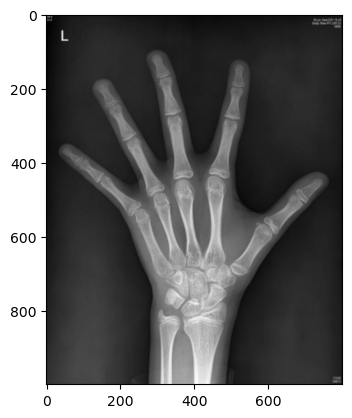

In [6]:
temp_img = cv2.imread('골밀도 데이터/pre_image/187.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(temp_img, 'gray')

> Thresholding
+ 0(검은색), 255(흰색)로 이진화

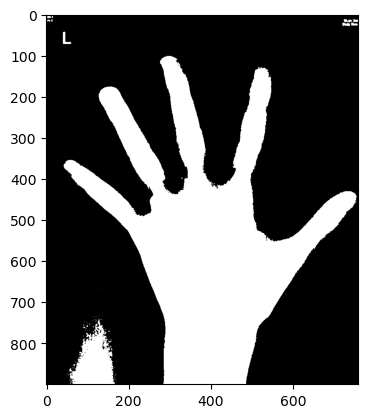

In [7]:
r_img = np.copy(temp_img)
height, width = temp_img.shape
img = temp_img[0:(int)(height*0.9),0:(int)(width*0.95)]

# 픽셀 값의 평균 크면 255로 설정되고 작으면 0으로 설정정
ret, img = cv2.threshold(img, temp_img.mean(), 255, cv2.THRESH_BINARY)

#샘플 이미지 Thresholding 결과
plt.imshow(img,"gray")

### 이미지 contouring

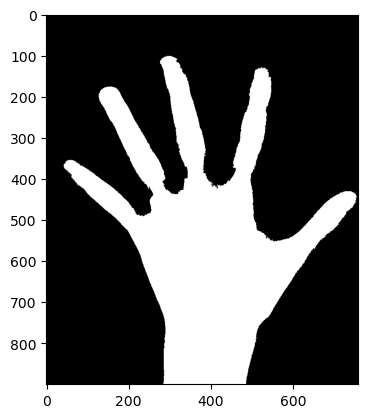

In [8]:
contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#외곽선 검출하여 mask 그리기
max_cnt = max(contours, key=cv2.contourArea)

mask = np.zeros(img.shape, dtype=np.uint8)
cv2.drawContours(mask, [max_cnt], -1, (255,255,255), -1)

plt.imshow(mask, 'gray')

### 첫 번째 흰색 좌표 구하기
+ 첫 번째 흰색 좌표가 중지 끝임

In [9]:
M = cv2.moments(max_cnt)
center = (int(M['m10']/M['m00']), int(M['m01']/M['m00']))

for y,x_r in enumerate(mask) :
    if 255 in x_r:
        #y에 따른 x rows 중 255인 x값 추출
        x_255_indexs = np.where(x_r == 255)[0]

        #255인 x값들 중 median 추출
        x_255_mid_index = x_255_indexs[len(x_255_indexs)//2]
        first_255_x_point = x_255_mid_index

        first_255_y_point = y
        break
        
print((first_255_x_point,first_255_y_point))
        

(298, 102)


### 무게중심과 좌표의 각도 구하여 회전

In [10]:
# 이미지 회전 함수 정의
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR,borderValue=(255,255,255))
    return result

In [11]:
# 무게중심과 첫 흰색 좌표 차이
center_x, center_y = center[0], center[1]
rx = abs(first_255_x_point - center_x)
ry = center_y - first_255_y_point

# 회전 각도 구하기
import math
radian = math.atan2(ry, rx)
degree = 90 - math.degrees(radian)
print('회전각도 :', degree)

# 무게중심과 첫 좌표 위치에 따라 회전 방향 조정

if first_255_x_point < center_x :
    mask = rotate_image(mask,360-degree) 
    r_img_ = rotate_image(temp_img,360-degree)
else:
    mask = rotate_image(mask,degree) 
    r_img_ = rotate_image(temp_img,degree) 

회전각도 : 11.63363399894044


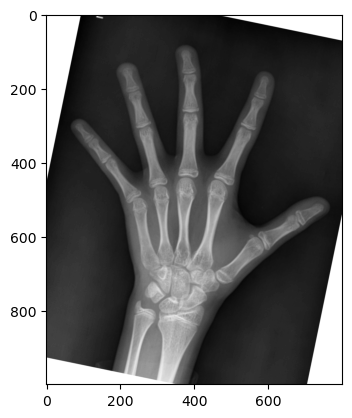

In [12]:
plt.imshow(r_img_, 'gray')

### 전체 이미지 회전

In [31]:
rotate_image_folder = '골밀도 데이터/rotate_image/'
os.makedirs(rotate_image_folder, exist_ok=True)

In [32]:
rotate_img=[]
for i in range(0,len(data)):
    img_path = glob.glob(pre_image_folder + total_df.id[i])[0]
    
    img_name = img_path.split('/')[-1]
    img0 = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    #이미지 thresholding
    r_img = np.copy(img0)
    height, width = img0.shape
    img = img0[0:(int)(height*0.9),0:(int)(width*0.95)]
    ret, img = cv2.threshold(img, img0.mean(), 255, cv2.THRESH_BINARY)
    
    #이미지 contouring
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key=cv2.contourArea)
    mask = np.zeros(img.shape, dtype=np.uint8)
    cv2.drawContours(mask, [max_cnt], -1, (255,255,255), -1)
    
    #이진화 이미지에서 1차 모멘트 구하기
    M = cv2.moments(max_cnt) 
    center = ( int(M['m10'] / M['m00']), int(M['m01'] / M['m00']) )

    #중지 끝 좌표 구하기
    for y,x_r in enumerate(mask) :
        if 255 in x_r:
            #y에 따른 x rows 중 255인 x값 추출
            x_255_indexs = np.where(x_r == 255)[0]

            #255인 x값들 중 median 추출
            x_255_mid_index = x_255_indexs[(int)(len(x_255_indexs)/2)]
            first_255_x_point = x_255_mid_index

            first_255_y_point = y
            break
    
    #중심점의 좌표 기준 첫 흰색 좌표와 차이 구하기
    half_h, half_w = center[1], center[0]
    ry = half_h-first_255_y_point 
    rx = abs(first_255_x_point-half_w)

    #차이 이용하여 회전 각도 구하기
    radian = math.atan2(ry,rx)
    degree = 90 - (radian * 180 / math.pi)


    #중심점 좌표와 첫 흰색 좌표 위치에 따라 회전 방향 조정
    if first_255_x_point < half_w :
        mask = rotate_image(mask,360-degree) 
        r_img_ = rotate_image(img0,360-degree)
    else:
        mask = rotate_image(mask,degree) 
        r_img_ = rotate_image(img0,degree) 

    #이미지 저장
    cv2.imwrite(rotate_image_folder + img_name, r_img_)